In this notebook we attempt to reproduce the results from the paper "U-Net: Convolutional Networks for Biomedical Image Segmentation". We only focus on the ISBI 2012 dataset, as this was the only one we could get our hands on.

We start by installing the necessary packages

We start by installing the necessary packages

In [1]:
from torch_snippets import Dataset, stems, read, cv2, randint, DataLoader, nn, torchvision, optim, Report
from torchvision import transforms
from pathlib import PurePath
import numpy as np
import math
import torch 
from torchsummary import summary
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

2021-09-01 20:07:09.860 | WARNING  | torch_snippets.torch_loader:<module>:233 - Not importing Lightning Report
2021-09-01 20:07:11.611 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [2]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

Define the Dataset class with its built in augmentation mechanism

In [3]:
class SegData(Dataset):
    def __init__(self, aug=None):
        self.items = stems('isbi-datasets-master/data/deformed_images')
        self.aug = aug
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        name = PurePath(self.items[ix]).name[-5:]
        image = read(f'isbi-datasets-master/data/deformed_images/train-volume{name}.jpg',1)
        image = cv2.resize(image, (572,572))
        mask = read(f'isbi-datasets-master/data/deformed_binary_labels/train-labels{name}.png')
        mask = cv2.resize(mask, (572,572))
        with open('isbi-datasets-master/data/wx/wx' + name + '.npy', 'rb') as file:
            wx = np.load(file)
        return image, mask, wx
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, masks, wxs = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(DEVICE)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(DEVICE)
        wxs = torch.cat([torch.Tensor(wx[None]) for wx in wxs]).float().to(DEVICE)
        return ims, ce_masks, wxs

Create the dataset instance

In [4]:
trn_ds = SegData()
trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True, collate_fn=trn_ds.collate_fn)

2021-09-01 20:07:23.873 | INFO     | torch_snippets.loader:stems:66 - 300 files found at isbi-datasets-master/data/deformed_images


Define the down and up convolutional blocks

More importantly, however, unless you can explicitly justify it, I advise against using BatchNormalization with batch_size=1; there are strong theoretical reasons against it, and multiple publications have shown BN performance degrade for batch_size under 32, and severely for <=8. In a nutshell, batch statistics "averaged" over a single sample vary greatly sample-to-sample (high variance), and BN mechanisms don't work as intended.

In [5]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0),
        nn.ReLU(inplace=True)
    )

In [6]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

Now, the fun starts when we define the network architecture. The notation convXY means layer X and conv number Y in that layer. Where a layer is the level in the U-Net drawing figure 1 in the paper.

Why does the nn.init.normal_(...) function divide the fan_out with 2 before generating the Gaussian distributed real numbers? Actually in the paper the quantity sqrt(2/N) is mentioned:

It can be seen on the histogram later that removing the self._init_weights() below results in uniformly random numbers and not Gaussian.

In [7]:
class UNet(nn.Module):
    def __init__(self, out_channels=2):
        super().__init__()

        self.conv11 = conv(3, 64)
        self.conv12 = conv(64, 64)

        self.conv21 = conv(64, 128)
        self.conv22 = conv(128, 128)

        self.conv31 = conv(128, 256)
        self.conv32 = conv(256, 256)

        self.conv41 = conv(256, 512)
        self.conv42 = conv(512, 512)

        self.conv51 = conv(512, 1024)
        self.conv52 = conv(1024, 1024)

        self.up_conv5 = up_conv(1024, 512)
        self.conv43 = conv(512 + 512, 512)
        self.conv44 = conv(512, 512)

        self.up_conv4 = up_conv(512, 256)
        self.conv33 = conv(256 + 256, 256)
        self.conv34 = conv(256, 256)

        self.up_conv3 = up_conv(256, 128)
        self.conv23 = conv(128 + 128, 128)
        self.conv24 = conv(128, 128)

        self.up_conv2 = up_conv(128, 64)
        self.conv13 = conv(64 + 64, 64)
        self.conv14 = conv(64, 64)
        self.conv15 = nn.Conv2d(64, out_channels, kernel_size=1)

        self.maxPool = nn.MaxPool2d(2)

        self.crop1 = torchvision.transforms.CenterCrop((392,392))
        self.crop2 = torchvision.transforms.CenterCrop((200,200))
        self.crop3 = torchvision.transforms.CenterCrop((104,104))
        self.crop4 = torchvision.transforms.CenterCrop((56,56))

        self.ReLU = nn.ReLU(inplace=True)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if type(m) in {
                nn.Linear,
                nn.Conv2d,
                nn.ConvTranspose2d
            }:
                _, fan_out = nn.init._calculate_fan_in_and_fan_out(m.weight.data)
                std = 1 / math.sqrt(fan_out / 2)
                nn.init.normal_(m.weight.data, 0, std)
                if m.bias is not None:
                    nn.init.normal_(m.weight.data, 0, std)

    def forward(self, x):               # 572*572

        x = self.conv11(x)              # 570*570
        block1 = self.conv12(x)         # 568*568
        x = self.maxPool(block1)        # 284*284
       
        x = self.conv21(x)              # 282*282

        block2 = self.conv22(x)         # 280*280
        x = self.maxPool(block2)        # 140*140
       
        x = self.conv31(x)              # 138 * 138
        block3 = self.conv32(x)         # 136 * 136
        x = self.maxPool(block3)        # 68 * 68

        x = self.conv41(x)              # 66*66
        block4 = self.conv42(x)         # 64*64 
        x = self.maxPool(block4)        # 32*32

        x = self.conv51(x)              # 30*30
        x = self.conv52(x)              # 28*28
        x = self.up_conv5(x)            # 56*56

        block4 = self.crop4(block4)     # 56*56
        x = torch.cat([x, block4], dim=1) 
        x = self.conv43(x)              # 54*54
        x = self.conv44(x)              # 52*52
        x = self.up_conv4(x)            # 104*104

        block3 = self.crop3(block3)     # 104*104
        x = torch.cat([x, block3], dim=1) 
        x = self.conv33(x)              # 102*102
        x = self.conv34(x)              # 100*100
        x = self.up_conv3(x)            # 200*200

        block2 = self.crop2(block2)     # 200*200
        x = torch.cat([x, block2], dim=1) 
        x = self.conv23(x)              # 198*198
        x = self.conv24(x)              # 196*196
        x = self.up_conv2(x)            # 392*392
        
        block1 = self.crop1(block1)     # 392*392
        x = torch.cat([x, block1], dim=1) 
        x = self.conv13(x)              # 390*390
        x = self.conv14(x)              # 388*388
        x = self.conv15(x)              # 388*388
        x = self.ReLU(x)                # 388*388
        
        return x

Now we would like to know the input and mask tensors a bit better so we can appreciate the data processing that the model does

In [8]:
MODEL = UNet().to(DEVICE)
summary(MODEL, (3,572,572));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 570, 570]        --
|    └─Conv2d: 2-1                       [-1, 64, 570, 570]        1,792
|    └─ReLU: 2-2                         [-1, 64, 570, 570]        --
├─Sequential: 1-2                        [-1, 64, 568, 568]        --
|    └─Conv2d: 2-3                       [-1, 64, 568, 568]        36,928
|    └─ReLU: 2-4                         [-1, 64, 568, 568]        --
├─MaxPool2d: 1-3                         [-1, 64, 284, 284]        --
├─Sequential: 1-4                        [-1, 128, 282, 282]       --
|    └─Conv2d: 2-5                       [-1, 128, 282, 282]       73,856
|    └─ReLU: 2-6                         [-1, 128, 282, 282]       --
├─Sequential: 1-5                        [-1, 128, 280, 280]       --
|    └─Conv2d: 2-7                       [-1, 128, 280, 280]       147,584
|    └─ReLU: 2-8                         [-1, 128, 280, 280]       --

C:\Users\janop\anaconda3\Lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


We now venture into defining the loss function from the paper. Here p is the predicted value (ground truth) and y is the NN output. d is the distance transform that belongs to the input image and that was defined in the data preparation stage.

First we read the wc map from file and center crop it to 388*388 size to fit the NN output. The cropping could have been done in the data preparation stage. We also init the hyper parameters w0 and sigma that are used to define the loss function.

In [9]:
with open(r'isbi-datasets-master\data\wc.npy', 'rb') as f:
    wc  = torch.from_numpy(np.load(f)).to(DEVICE)
    wc0 = torchvision.transforms.CenterCrop((388,388))(wc[:,:,0])
    wc1 = torchvision.transforms.CenterCrop((388,388))(wc[:,:,1])
    wc = torch.cat((wc0.unsqueeze(0),wc1.unsqueeze(0)),0).unsqueeze(0)

W0    = 10
SIGMA = 5
BETA  = 1 # exp(base) of exponential in softmax function
crop  = torchvision.transforms.CenterCrop((388,388))

In [10]:
def UnetLoss(outputs, targets, weights):
    num_examples = targets.shape[1] * targets.shape[2]
    targets = torch.unsqueeze(targets,1)
    outputs = outputs - torch.logsumexp(outputs,dim=1, keepdim=True)
    outputs = torch.gather(outputs,1,targets)[0,0,:,:]
    weights = weights + torch.gather(wc,2,targets)[0,0,:,:]
    outputs = outputs * weights
    return - torch.sum(outputs)/num_examples

In [11]:
def my_cross_entropy_loss(outputs, targets):
    num_examples = targets.shape[1] * targets.shape[2]
    targets = torch.unsqueeze(targets,1)
    outputs = outputs - torch.logsumexp(outputs,dim=1, keepdim=True)
    outputs = torch.gather(outputs,1,targets)[0,0,:,:]
    return - torch.sum(outputs)/num_examples

Before entering the training loop let us do some sanity tests on the loss function. On an output that matches the mask we would like minimum loss, on an output that is the negation (255 - y) of the mask we would like maximum loss. Anything in between should give loss between these values.

In summary we get minimum loss 0 and maximum loss ~ 1258570. The actual loss for the given input is ~ 629104. Which is consistent.

Before the training loop we define the what is inside it:

In [12]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    im, mask, weights = data
    out  = model(im)
    mask = crop(mask)
    mask = torch.unsqueeze(torch.where(mask[0,:,:] == 0, 0, 1), 0)
    weights = crop(weights[0])
    optimizer.zero_grad()
    loss = criterion(out, mask, weights)
    loss.backward()
    optimizer.step()
    return loss.item()

In [13]:
model = UNet().to(DEVICE)
criterion = UnetLoss
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)
n_epochs = 50
log = Report(n_epochs)
train_losses = []

for ex in range(n_epochs):
    N = len(trn_dl)
    train_epoch_losses = []
    for bx, data in enumerate(trn_dl):
        loss = train_batch(model, data, optimizer, criterion)
        train_epoch_losses.append(loss) 
        log.record(ex + (bx+1)/N, trn_loss=loss, trn_acc=1.0, end='\r')
    train_epoch_loss = np.array(train_epoch_losses).mean()

    train_losses.append(train_epoch_loss)
    log.report_avgs(ex+1)

print('Training complete')

EPOCH: 1.000	trn_loss: 3.022	trn_acc: 1.000	(349.41s - 17120.98s remaining)
EPOCH: 2.000	trn_loss: 2.852	trn_acc: 1.000	(719.31s - 17263.38s remaining)
EPOCH: 3.000	trn_loss: 2.820	trn_acc: 1.000	(1086.33s - 17019.25s remaining)
EPOCH: 4.000	trn_loss: 2.793	trn_acc: 1.000	(1443.49s - 16600.15s remaining)
EPOCH: 5.000	trn_loss: 2.760	trn_acc: 1.000	(1798.34s - 16185.08s remaining)
EPOCH: 6.000	trn_loss: 2.723	trn_acc: 1.000	(2153.53s - 15792.52s remaining)
EPOCH: 7.000	trn_loss: 2.691	trn_acc: 1.000	(2508.06s - 15406.63s remaining)
EPOCH: 8.000	trn_loss: 2.600	trn_acc: 1.000	(2862.70s - 15029.16s remaining)
EPOCH: 9.000	trn_loss: 2.597	trn_acc: 1.000	(3217.16s - 14655.94s remaining)
EPOCH: 10.000	trn_loss: 2.478	trn_acc: 1.000	(3572.29s - 14289.16s remaining)
EPOCH: 11.000	trn_loss: 2.415	trn_acc: 1.000	(3926.58s - 13921.52s remaining)
EPOCH: 12.000	trn_loss: 2.379	trn_acc: 1.000	(4281.26s - 13557.32s remaining)
EPOCH: 13.000	trn_loss: 2.296	trn_acc: 1.000	(4635.73s - 13193.99s remainin

  0%|          | 0/151 [00:00<?, ?it/s]


AttributeError: 'Report' object has no attribute 'val_loss'

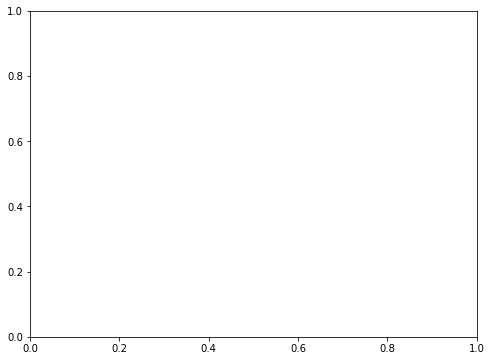

In [14]:
log.plot_epochs(['trn_loss','val_loss'])

In [15]:
with open('train_epoch_losses_20_epoch_weighted_CE_loss.npy', 'wb') as f:
    np.save(f, train_losses)

Read the losses so that we can display the,

In [16]:
with open('train_epoch_losses_20_epoch_weighted_CE_loss.npy', 'rb') as f:
    train_losses = np.load(f)

ValueError: x and y must have same first dimension, but have shapes (20,) and (50,)

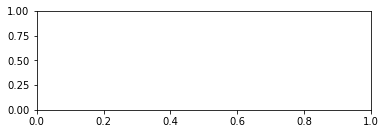

In [17]:
epochs = np.arange(20)+1
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training loss with 0.01 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

In [18]:
torch.save(model, '20_epoch_weighted_CE_loss.pt')

In [19]:
im, Mask, dist_transform = next(iter(trn_dl))
out = model(im)

Lets display, in order: The input image, the mask (ground truth) and the output image

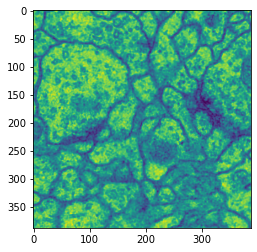

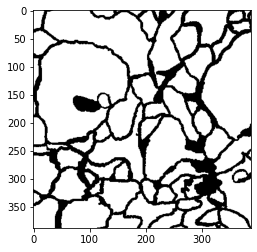

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


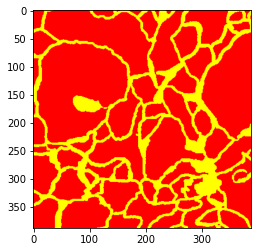

In [20]:
mask0 = torchvision.transforms.CenterCrop((388,388))(Mask)
mask0 = torch.moveaxis(mask0, 0, 2)

im = crop(im)
plt.imshow(im[0].permute(1,2,0).detach().cpu()[:,:,0])
plt.show()
mask0 = torch.cat((mask0, mask0, mask0), 2)
plt.imshow(mask0.detach().cpu())
plt.show()

out1=out[0,:,:,:]
white = torch.full((1, 388, 388), 255,device=DEVICE)
out1 = torch.cat((white, out1),0)
out1 = out1.permute(1,2,0)
plt.imshow(out1.detach().cpu())
plt.show()